# Exploration of generated molecules
1. There is a function to load the grid form the visualization files: `util.timesdata_to_array` but this only loads the grid and not the channels as shown below.
2. Luisa wrote the generated grid data to some `.npy` files that we will be exploring.

In [1]:
import numpy as np
import sys
sys.path.append("../zeodiff") # we did not install zeodiff, thus use this trick to access all members

### 1. Loading data from visualization files

In [2]:
from util import timesdata_to_array
samples_vf_40 = timesdata_to_array(root="../generated_samples/sample_vf_0.40/")

In [3]:
samples_vf_40.shape

(10, 32, 32, 32)

In [5]:
samples_vf_40[1].shape

(32, 32, 32)

In [6]:
# furthermore the values are those of the energy (see high values like 5000)
samples_vf_40[1][3][:]

array([[1095.1825 , 3495.5574 , 4953.8447 , ..., 5003.782  , 4975.7207 ,
        5052.597  ],
       [ 909.37317, 2309.8848 , 4933.8257 , ..., 4949.3486 , 4985.4766 ,
        5020.1055 ],
       [1083.5867 , 2077.7974 , 4980.6826 , ..., 4941.6777 , 4934.7817 ,
        4995.852  ],
       ...,
       [3355.6475 , 4930.271  , 4956.8936 , ..., 4929.643  , 4946.9614 ,
        4957.6445 ],
       [1658.5724 , 4977.0864 , 4964.0957 , ..., 4951.7676 , 4972.768  ,
        4957.657  ],
       [1156.3905 , 4366.663  , 5005.172  , ..., 5055.1196 , 5021.4634 ,
        4892.675  ]], dtype=float32)

### 2. Contents of generated sample.npy
(Written at the same time as visualization files)

In [7]:
sample_1=np.load('../generated_samples/sample_hoa_50/sample_1.npy')
sample_1.shape

(3, 32, 32, 32)

3 channels (energy, Si, O) and the grid is of 32x32x32

In [9]:
sample_1[2][15][15][:]

array([ 1.01412674,  1.00971892,  1.00577844,  0.99769692,  0.92046827,
        0.71211934,  0.26537039, -0.30304992, -0.68353709, -0.59158238,
       -0.09274182,  0.45370068,  0.7971047 ,  0.94114468,  0.9784056 ,
        0.98846922,  0.99152488,  1.00143716,  0.99705286,  0.99397015,
        0.93878065,  0.83869534,  0.55335508,  0.02878011, -0.5876046 ,
       -0.79151711, -0.39350426,  0.23464134,  0.71162723,  0.93724729,
        0.99483938,  1.01251825])

In [10]:
sample_1[1][15][15][:]

array([0.98875122, 0.99085394, 0.9902666 , 0.97686336, 0.96848934,
       0.92041752, 0.80772567, 0.66015638, 0.54728664, 0.56987226,
       0.70643152, 0.84665833, 0.93736984, 0.96715632, 0.97171982,
       0.98410123, 0.97843469, 0.98438819, 0.97851007, 0.97880465,
       0.95755588, 0.91392416, 0.81641915, 0.66818928, 0.57474868,
       0.61791164, 0.77120081, 0.8902063 , 0.95048094, 0.97439632,
       0.98049205, 0.99449726])

👀 Notice that the Si and O high values (i.e atom centers) are spatially correlated -> In the same positions.

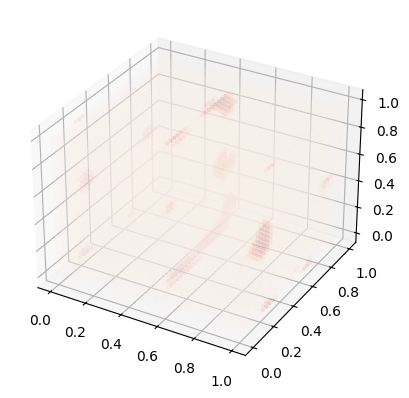

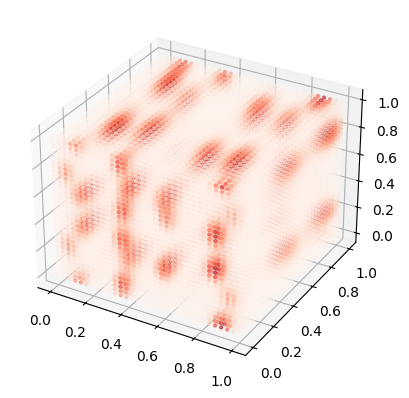

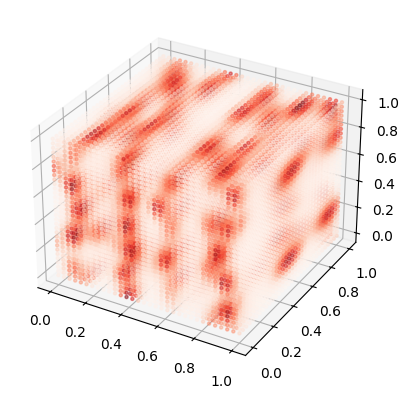

In [11]:
from dataset import visualize_3d
visualize_3d(sample_1, 0) # griddata -> energy
visualize_3d(sample_1, 1) # Si
visualize_3d(sample_1, 2) # O

Threshold the values to only see the atom's centers

In [20]:
sample_1_tresholded=sample_1.copy()
sample_1_tresholded[sample_1_tresholded < 0.98] = 0

In [21]:
sample_1_tresholded[1,1,1,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.98064405, 0.        ,
       0.98457217, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [22]:
import matplotlib.pyplot as plt
import numpy as np
x,y,z = np.mgrid[0:1:32j, 0:1:32j, 0:1:32j]
#energy = sample_1_tresholded[0,:,:,:]
Si = sample_1_tresholded[1,:,:,:]
O = sample_1_tresholded[2,:,:,:]

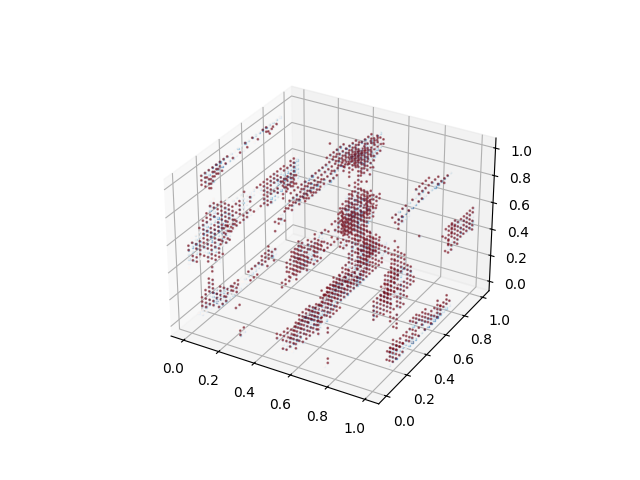

In [23]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mask_O =(O >= 0.999)

ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=O[mask_O], cmap='Blues', s=1, alpha=0.5, marker='s')
ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=Si[mask_O], cmap='Reds', s=1, alpha=0.5)

👀 I see here that the blue and red symbols are superposed in most cases.  

In [12]:
def plot_sample(n: int):
    """Makes a 3d interactive plot of the Silicium and Oxigen atoms in a generated zeolyte
       Args:
       - n: id of the sample
    """
    import numpy as np
    import sys
    import matplotlib.pyplot as plt
    sys.path.append("../zeodiff") # we didnt install zeodiff, thus use this trick to access all members
    sample_n=np.load(f"../generated_samples/sample_hoa_50/sample_{n}.npy")

    x,y,z = np.mgrid[0:1:32j, 0:1:32j, 0:1:32j]
    #energy = sample_n[0,:,:,:]
    Si = sample_n[1,:,:,:]
    O = sample_n[2,:,:,:]

    %matplotlib widget
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    mask_O =(O >= 0.999)

    ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=Si[mask_O], cmap='Reds', s=1, alpha=0.5)
    ax.scatter(x[mask_O], y[mask_O], z[mask_O], c=O[mask_O], cmap='Blues', s=1, alpha=0.5, marker='s')

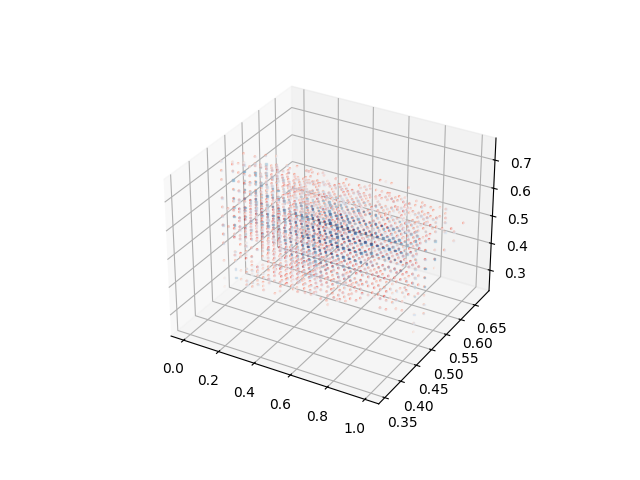

In [14]:
plot_sample(3)